# Predictive Coding network

In [1]:
import torch
from torch import nn
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchvision

In this notebook, we implement a predictive coding network according to the design porposed by Rao and Ballard. This is a sandback experiment illustrating the learning and inference processes of predictive coding. We additionnally experimentally verify that these processes minimize variational-free energy.

The model is defined in the following class. It is a two-layered perceptron with PC inference and learning mechanisms.

In [2]:
class PCNetwork(nn.Module):
    
    def __init__(self, input_dim, states_dim, output_dim, alpha, sigma_h, sigma_x):
        super(PCNetwork, self).__init__()
        
        self.input_dim = input_dim
        self.states_dim = states_dim
        self.output_dim = output_dim
        self.alpha = alpha
        self.sigma_h = sigma_h
        self.sigma_x = sigma_x
        
        # Input weights initialization
        self.w_i = torch.randn(self.states_dim, self.input_dim) / self.states_dim
        
        # Output weights initialization
        self.w_o = torch.randn(self.output_dim, self.states_dim) / self.states_dim
        
        # Predictions, states and errors are temporarily stored for batch learning
        # Learning can be performed online, but computations are slower
        self.x_pred = None
        self.x_error = None
        self.h_prior = None
        self.h_post = None
        self.h_error = None
        self.c_prior = None
        self.c_post = None
        
    def forward(self, x, old_h_post=0, c_prior=0, store=True):
        """
        Pass through the network : forward (prediction) and backward (inference) passes are 
         performed at the same time.
        Parameters :        
        - x : target output, Tensor of shape (batch_size, output_dim)
        - old_h_post : input, Tensor of shape (batch_size, states_dim)
        - c_prior : input, Tensor of shape (batch_size, input_dim)
        """

        batch_size, _ = x.shape       
        
        # Top-down pass
        h_prior = (1-1/self.sigma_h**2) * old_h_post + 1/self.sigma_h**2 * torch.mm(c_prior, self.w_i.T)
        
        x_pred =  torch.mm(torch.tanh(h_prior), self.w_o.T)

        # Bottom-up pass

        # Compute the error on the output level
        x_error = x_pred - x

        # Infer h_post according to h_prior and the error on the output level
        h_post = h_prior - (self.alpha/self.sigma_x**2)*(1-torch.tanh(h_prior)**2)*torch.mm(x_error, self.w_o)
            
        # Compute the error on the hidden level
        h_error = h_prior - h_post
            
        # Infer c_post according to c_prior and the error on the hidden level
        c_post = c_prior - (self.alpha/self.sigma_h**2)*torch.mm(h_error, self.w_i)
            
        if store:
            self.x_error = x_error
            self.x_pred = x_pred
            self.h_prior = h_prior
            self.h_post = h_post
            self.h_error = h_error
            self.c_prior = c_prior
            self.c_post = c_post

        return x_error

    def learn(self, lr_o, lr_i):
        """
        Performs learning of the network weights.
        Parameters :
        - lr_o : Learning rate on the output weights
        - lr_i : Learning rate on the input weights
        """

        batch_size, _ = self.x_pred.shape
        
        # Output weights
        grad_o = torch.mean(
            torch.bmm(
                torch.tanh(self.h_prior.reshape(batch_size, self.states_dim, 1)),
                self.x_error.reshape(batch_size, 1, self.output_dim)
            ),
            axis=0
        )
        
        self.w_o -= lr_o * grad_o.T
        
        # Output weights
        grad_i = torch.mean(
            torch.bmm(
                self.c_prior.reshape(batch_size, self.input_dim, 1),
                self.h_error.reshape(batch_size, 1, self.states_dim)
            ),
            axis=0
        )
        
        self.w_i -= lr_i * grad_i.T
        
    def vfe(self):
        """
        Computes the variational free-energy associated with the last seen values, up to a constant term
        """
        
        vfe = torch.zeros(2)  # We measure the contribution of each layer: X and H
        vfe[0] = 0.5 * torch.mean(torch.sum(self.x_error ** 2, axis=1)) / self.sigma_x**2
        vfe[1] = 0.5 * torch.mean(torch.sum(self.h_error ** 2, axis=1)) / self.sigma_h**2
        return vfe

We train this model on 4 patterns representing digits in an 4x5 pixel grid. The four patterns are displayed here:

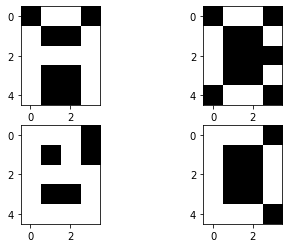

In [3]:
patterns = torch.Tensor([
    [
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 1., 1., 1.],
        [1., 0., 0., 1.],
        [1., 0., 0., 1],
    ],
    [
        [1., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 1., 1.],
        [1., 0., 0., 1.],
        [1., 1., 1., 1.],
    ],
    [
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [0., 1., 1., 0.],
    ],
    [
        [1., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 0., 1.],
        [1., 0., 0., 1.],
        [1., 1., 1., 0.],
    ]
])

fig = plt.figure()
axes = fig.subplots(2, 2)

axes[0, 0].imshow(patterns[0], cmap='gray')
axes[1, 0].imshow(patterns[1], cmap='gray')
axes[0, 1].imshow(patterns[2], cmap='gray')
axes[1, 1].imshow(patterns[3], cmap='gray')

plt.show()

In [4]:
pcnet = PCNetwork(4, 10, 20, alpha=1, sigma_h=1, sigma_x=1)

iterations = 50

vfes = torch.zeros(iterations, 2)
losses= torch.zeros(iterations)

for i in tqdm(range(iterations)):
    x_error = pcnet.forward(patterns.reshape(4, 20), torch.zeros(4, 10), torch.eye(4))
    losses[i] = torch.mean(torch.sum(x_error**2, axis=1))
    vfes[i] = pcnet.vfe()
    pcnet.learn(0.3, 0.3)

  0%|          | 0/50 [00:00<?, ?it/s]

We can display the evolution of the VFE and the prediction error (L2 loss) during learning.

Additionally, we show the contribution of each layer of the network to the VFE:

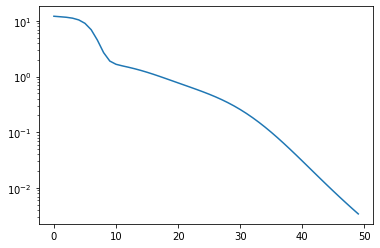

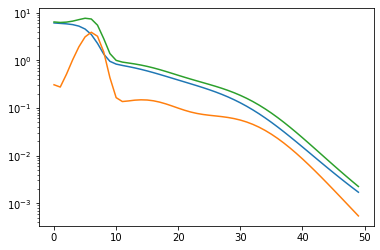

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(range(iterations), losses)
plt.yscale('log')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(iterations), vfes[:, 0])
plt.plot(range(iterations), vfes[:, 1])
plt.plot(range(iterations), torch.sum(vfes, axis=1))
plt.yscale('log')
plt.show()

## Using the network in prediction mode

After training, initializing the top layer of the network (the layer we called input in the code) with the one-hot values encoding the data set labels properly regenerates the target patterns.

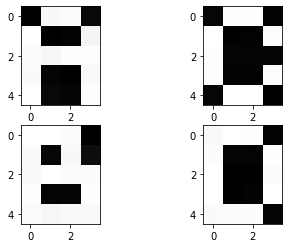

In [6]:
pcnet.forward(torch.zeros(4, 20), torch.zeros(4, 10), torch.eye(4))

fig = plt.figure()
axes = fig.subplots(2, 2)

axes[0, 0].imshow(pcnet.x_pred[0].reshape(5, 4), cmap='gray')
axes[1, 0].imshow(pcnet.x_pred[1].reshape(5, 4), cmap='gray')
axes[0, 1].imshow(pcnet.x_pred[2].reshape(5, 4), cmap='gray')
axes[1, 1].imshow(pcnet.x_pred[3].reshape(5, 4), cmap='gray')

plt.show()

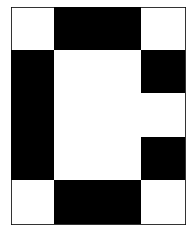

In [7]:
plt.imshow(1-patterns[2].reshape(5, 4), cmap='gray')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

## Using the network in inference mode

After training, we can also perform classification with this model. We provide it with a neutral input, for instance [0.25, 0.25, 0.25, 0.25], and one of the target patterns, here, the pattern "C". We reuse the inferred $c$ value as input for the next trial. After a few trials, the value of $c$ converges the correct label.

In [8]:
trials = 15

cs = torch.zeros(trials+1, 4)
cs[0] = torch.Tensor([0.25, 0.25, 0.25, 0.25])

x_preds = torch.zeros(trials, 20)
h_posts = torch.zeros(trials+1, pcnet.states_dim)
h_priors = torch.zeros(trials, pcnet.states_dim)
vfes = torch.zeros(trials, 2)

pcnet.alpha=0.2

for t in tqdm(range(trials)):
    pcnet.forward(patterns[2].reshape(1, 20), h_posts[t:t+1], cs[t:t+1])
    cs[t+1] = pcnet.c_post[0]
    x_preds[t] = pcnet.x_pred
    h_posts[t+1] = pcnet.h_post
    h_priors[t] = pcnet.h_prior
    vfes[t] = pcnet.vfe()

  0%|          | 0/15 [00:00<?, ?it/s]

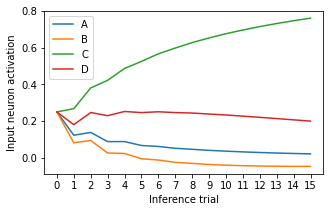

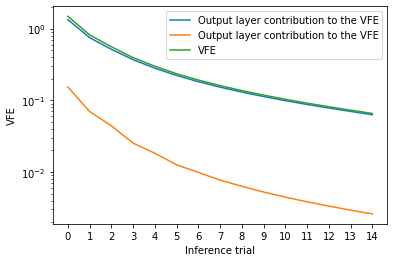

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(range(trials+1), cs[:, 0], label='A')
plt.plot(range(trials+1), cs[:, 1], label='B')
plt.plot(range(trials+1), cs[:, 2], label='C')
plt.plot(range(trials+1), cs[:, 3], label='D')
plt.xticks(range(trials+1))
plt.xlabel('Inference trial')
plt.ylabel('Input neuron activation')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(trials), vfes[:, 0], label='Output layer contribution to the VFE')
plt.plot(range(trials), vfes[:, 1], label='Output layer contribution to the VFE')
plt.plot(range(trials), torch.sum(vfes, axis=1), label='VFE')
plt.yscale('log')
plt.xticks(range(trials))
plt.xlabel('Inference trial')
plt.ylabel('VFE')
plt.legend()
plt.show()

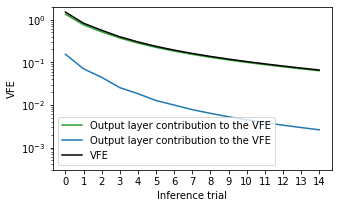

In [12]:
plt.figure(figsize=(5, 3))
plt.plot(range(trials), vfes[:, 0], label='Output layer contribution to the VFE', color='tab:green')
plt.plot(range(trials), vfes[:, 1], label='Output layer contribution to the VFE', color='tab:blue')
plt.plot(range(trials), torch.sum(vfes, axis=1), label='VFE', color='black')
plt.yscale('log')
plt.xticks(range(trials))
plt.xlabel('Inference trial')
plt.ylim(0.0003, 2)
plt.ylabel('VFE')
plt.legend()
plt.show()

We can see on this figure that after 50 trials, the network has recognized that the target pattern was of the category "C". Note that the inference can converge faster if we increase the coefficient $\alpha_x$ and $\alpha_h$. However, increasing them too much might cause the inference process to diverge. o have smoother figures here, we keep these coefficients very low. 

We can also plot the evolution of the network prediction over this inference process:

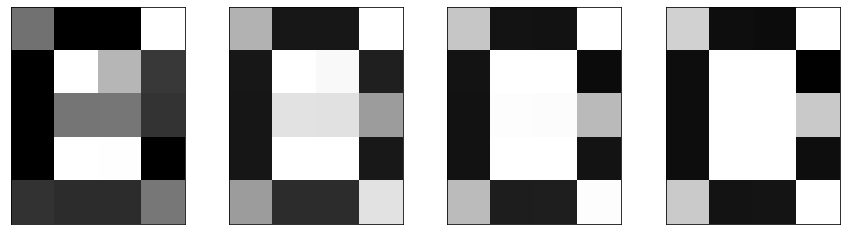

In [13]:
fig = plt.figure(figsize=(15, 4))
axes = fig.subplots(1, 4)

for k in range(4):
    axes[k].imshow(1-x_preds[k*4].reshape(5, 4), cmap='gray', vmin=0, vmax=1)
    axes[k].grid(False)
    axes[k].set_xticks([])
    axes[k].set_yticks([])

Additionnaly, we can represent the evolution of the prediction on the hidden layer throughout inference:

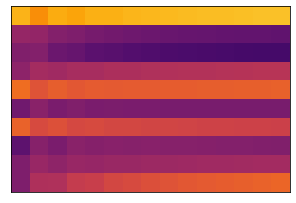

In [14]:
plt.figure(figsize=(5, 4))
plt.imshow(torch.tanh(h_priors.T), cmap='inferno', vmin=-1, vmax=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

We can argue that in this case, using a two-layered network might be useless. We voluntarily used two layers instead of one to show that the PC learning algorithm can propagate the teaching signal backward into the hierarchical generative model.